In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
#resources used:https://www.youtube.com/channel/UCCtkE-r-0Mvp7PwAvxzSdvw

/kaggle/input/ml-fall2019-android-malware/readme.pdf
/kaggle/input/ml-fall2019-android-malware/data/data/sample-solutions/sample.solution.all.positive.csv
/kaggle/input/ml-fall2019-android-malware/data/data/sample-solutions/sample.solution.half-neg.csv
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.train
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/eval.id
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.eval.anon
/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.test


In [2]:
## convert libsvm to sparse matrix
from scipy.sparse import csr_matrix
import numpy as np
import statistics
import glob
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing

In [3]:
from scipy.sparse import csr_matrix
import numpy as np
def read_libsvm(fname, num_features=0):
    '''
        Reads a libsvm formatted data and outputs the training set (sparse matrix)[1], 
        the label set and the number of features. The number of features
        can either be provided as a parameter or inferred from the data.

		Example usage:
		
		X_train, y_train, num_features = read_libsvm('data_train')
		X_test, y_test, _ = read_libsvm('data_test', num_features)

		[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
	'''
    data = []
    y = []
    row_ind = []
    col_ind = []
    with open(fname) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            elements = line.split()
            y.append(int(elements[0]))
            for el in elements[1:]:
                row_ind.append(i)
                c, v = el.split(":")
                col_ind.append(int(c))
                data.append(float(v))
    if num_features == 0:
        num_features = max(col_ind) + 1
    X = csr_matrix((data, (row_ind, col_ind)), shape=(len(y), num_features+1))

    return X, np.array(y), num_features

In [4]:
X_train, y_train, num_features = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.train',0)
X_test, y_test, _ = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.test', 0)
X_eval, y_eval, _ = read_libsvm('/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/data.eval.anon', 0)
X_train_df = pd.DataFrame(X_train.toarray())
X_test_df= pd.DataFrame(X_test.toarray())
X_eval_df = pd.DataFrame(X_eval.toarray())

In [5]:
def convert(col):
    #print(col)
    median = col.median()
    #print("m",median)
    col[col<median]=0
    col[col>median]=1
    return col

X_train_df = X_train_df.apply(convert,axis=0)
X_train_to = X_train_df.copy()
X_train_df['label'] = y_train

########    
X_test_df = X_test_df.apply(convert,axis=0)
X_eval_df = X_eval_df.apply(convert,axis=0)

In [6]:
def check_labels_same_data(data):
    
    label = data[:, -1]
    uniqueValues, _ = np.unique(label, return_counts=True)
    if len(uniqueValues) == 1:
        return True
    else:
        return False

In [7]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [8]:
def split_points(data):
    
    potential_splits = {}
    _, columns = data.shape
    for index in range(columns - 1):       
        values = data[:, index]
        uniqueValues, _ = np.unique(values, return_counts=True)
        potential_splits[index] = uniqueValues
    
    return potential_splits

In [9]:
def data_divide_2(data, split_column, split_value):  
    column_values = data[:, split_column]
    less_data = data[column_values == split_value]
    more_data = data[column_values != split_value]

    return less_data, more_data

In [10]:

def expected_entropy(data):
    
    label = data[:, -1]
    _, num = np.unique(label, return_counts=True)

    prob = num / num.sum()
    entropy = sum(prob * -np.log2(prob))
     
    return entropy

In [11]:
def calculate_entropy(less_data, more_data):
    
    n = len(less_data) + len(more_data)
    p_data_below = len(less_data) / n
    p_data_above = len(more_data) / n

    overall_entropy =  (p_data_below * expected_entropy(less_data) 
                      + p_data_above * expected_entropy(more_data))
    
    return overall_entropy

In [12]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = data_divide_2(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [13]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
     
    if (check_labels_same_data(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    else:

        counter += 1

        potential_splits = split_points(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = data_divide_2(data, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        feature_name = COLUMN_HEADERS[split_column]

        question = "{} = {}".format(feature_name, split_value)

        sub_tree = {question: []}

        true = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        false = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if true == false:
            sub_tree = true
        else:
            sub_tree[question].append(true)
            sub_tree[question].append(false)

        return sub_tree

In [14]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    if comparison_operator == "=":
        if example[int(feature_name)] == float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
     
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
    
        residual_tree = answer
        return classify_example(example, residual_tree)

In [15]:

def calculate_accuracy(df,tree):
    predict_list= df.apply(classify_example, args=(tree,), axis=1)
    return predict_list

> TRAINING DECISION TREE AND FINDING BEST DEPTH 

In [16]:
import collections, numpy
import sklearn.metrics as metrics

for d in [3,25,50,100]:
    print("depth=",d,"**********************")
    tree = decision_tree_algorithm(X_train_df,max_depth = d)    
    predict_list = calculate_accuracy(X_test_df, tree)
    y_predict = predict_list.tolist()
    print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
    print("Precision:",metrics.precision_score(y_test, y_predict))
    print("Recall:",metrics.recall_score(y_test, y_predict))

depth= 3 **********************
Accuracy: 0.7289608850256816
Precision: 0.5600843288826423
Recall: 0.9299883313885647
depth= 25 **********************
Accuracy: 0.8474911102331094
Precision: 0.7497348886532343
Recall: 0.8249708284714119
depth= 50 **********************
Accuracy: 0.8506519162386409
Precision: 0.7539766702014846
Recall: 0.8296382730455076
depth= 100 **********************
Accuracy: 0.8506519162386409
Precision: 0.7539766702014846
Recall: 0.8296382730455076


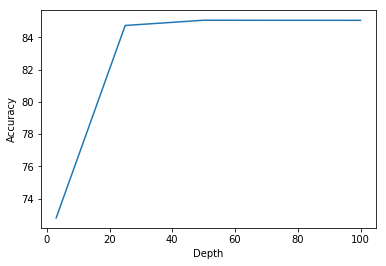

In [17]:
import matplotlib.pyplot as plt
plt.plot([3, 25, 50, 100], [72.8, 84.74, 85.065, 85.06])
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

TRAINING ACCURACY FOR BEST TREE

In [18]:
predict_list = calculate_accuracy(X_train_df, tree)
y_predict = predict_list.tolist()
print("Accuracy:",metrics.accuracy_score(y_train, y_predict))

Accuracy: 0.95643016980387


PREDICTING ON EVAL DATA

In [19]:
import collections, numpy
import sklearn.metrics as metrics

for d in [25]:
    print("depth= ",d)
    predict_list = calculate_accuracy(X_eval_df, tree)
    y_predict = predict_list.tolist()
    print(collections.Counter(y_predict))
y_predict = np.array(y_predict)
print(y_predict)
y_predict= np.where(y_predict==1.0,1,0)
print(y_predict)

depth=  25
Counter({0.0: 1593, 1.0: 939})
[1. 0. 1. ... 0. 0. 0.]
[1 0 1 ... 0 0 0]


CODE FOR DOWNLOADING CSV FILE

In [20]:
eval_id_list=[]
with open("/kaggle/input/ml-fall2019-android-malware/data/data/data-splits/eval.id") as f:
    lines = f.readlines()
    
for ele in lines:
    ele=ele.rstrip("\n")
    eval_id_list.append(ele) 

In [21]:
list_of_tuples = list(zip(eval_id_list, y_predict))  
    
# Assign data to tuples.  
list_of_tuples   
  
  
# Converting lists of tuples into  
# pandas Dataframe.  
df_new = pd.DataFrame(list_of_tuples, columns = ['example_id', 'label'])  
     
# Print data.  
df_new

,example_id,label
0,2591,1
1,10174,0
2,4764,1
3,5429,1
4,11235,0
...,...,...
2527,1681,0
2528,9320,0
2529,2301,0
2530,1175,0


In [22]:
df_new.to_csv(r'df_new.csv')
from IPython.display import FileLink
FileLink(r'df_new.csv')

/kaggle/working/df_new.csv